<a href="https://colab.research.google.com/github/Yumiuse/french-flashcard-portfolio/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

リポジトリを丸ごと取得

In [1]:
# Colabにドライブマウント（最初の１回だけ）
from google.colab import drive; drive.mount('/content/drive')

# CSVを読み込んで、バックアップ用フォルダにそのまま書き出し
import pandas as pd, os
src = '/content/drive/MyDrive/mettre_fin_Lexique_translated_v6w_修正済み.csv'
dst = '/content/drive/MyDrive/backup/df_backup.csv'
os.makedirs(os.path.dirname(dst), exist_ok=True)
pd.read_csv(src).to_csv(dst, index=False)
print("Saved:", dst)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved: /content/drive/MyDrive/backup/df_backup.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate


In [3]:
%cd /content/drive/MyDrive
!git clone https://github.com/Yumiuse/french-flashcard-portfolio.git


/content/drive/MyDrive
fatal: destination path 'french-flashcard-portfolio' already exists and is not an empty directory.


In [4]:
%cd /content/drive/MyDrive/french-flashcard-portfolio
!ls -1


/content/drive/MyDrive/french-flashcard-portfolio
data
README.md
train_model.py


In [5]:
%%writefile /content/drive/MyDrive/french-flashcard-portfolio/train_model.py
# ------ train_model.py の中身をここに丸ごと貼り付け ------

# …（省略せずスクリプト全文を貼ってください）…


Overwriting /content/drive/MyDrive/french-flashcard-portfolio/train_model.py


In [6]:
!git add train_model.py
!git commit -m "モデルスクリプト更新"
!git push


Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@23bbbbf18aac.(none)')
fatal: could not read Username for 'https://github.com': No such device or address


In [7]:
%cd /content/french-flashcard-portfolio
!ls -1

#data/ フォルダの中身を確認
!ls -l data
!python3 train_model.py

[Errno 2] No such file or directory: '/content/french-flashcard-portfolio'
/content/drive/MyDrive/french-flashcard-portfolio
data
README.md
train_model.py
total 22513
-rw------- 1 root root 23052575 May 16 04:45 mettre_fin_Lexique_translated_v6w_修正済み.csv


In [8]:
!pip install autopep8


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.7 MB/s eta 0:00:00


In [9]:
!autopep8 --in-place --aggressive --aggressive train_model.py


In [10]:
%cd /content/french-flashcard-portfolio/french-flashcard-portfolio
!ls -1
# ここに train_model.py が見えるはず
!python3 train_model.py


[Errno 2] No such file or directory: '/content/french-flashcard-portfolio/french-flashcard-portfolio'
/content/drive/MyDrive/french-flashcard-portfolio
data
README.md
train_model.py


▶ Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:59:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


▶ Evaluating on test set...
              precision    recall  f1-score   support

     Level 1      0.999     0.999     0.999     10603
     Level 2      0.997     0.994     0.995      9843
     Level 3      0.996     0.998     0.997     10067

    accuracy                          0.997     30513
   macro avg      0.997     0.997     0.997     30513
weighted avg      0.997     0.997     0.997     30513



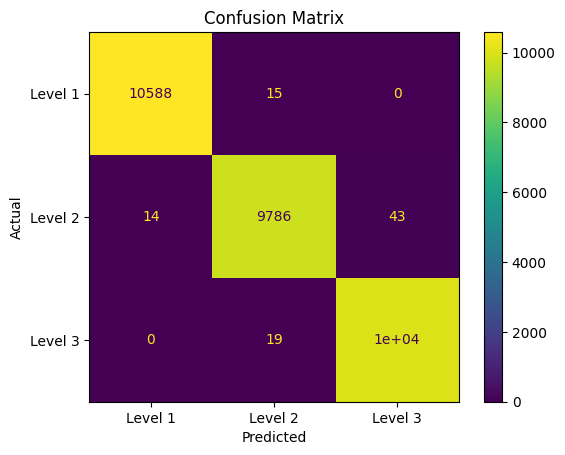

▶ Running Stratified K-Fold CV ...
accuracy: 0.997 ± 0.000
precision_macro: 0.997 ± 0.000
recall_macro: 0.997 ± 0.000
f1_macro: 0.997 ± 0.000


In [25]:

def main():
    # --- 1) データ読み込み ---
    df = pd.read_csv('data/mettre_fin_Lexique_translated_v6w_修正済み.csv')

    # --- 2) 欠損値補完 ---
    df['lemme'] = df['lemme'].fillna('')
    df['cgram'] = df['cgram'].fillna('unknown')
    df['genre'] = df['genre'].fillna('none')

    le = LabelEncoder()
    df['level_code'] = le.fit_transform(df['level'])  # ← ここで level_code を作成

    # --- 3) 数値特徴量追加 ---
    df['avg_freq'] = ((df['freqlemfilms2'] + df['freqlemlivres']) / 2).fillna(0)

    # --- 4) ラベルエンコード ---
    le = LabelEncoder()
    df['level_code'] = le.fit_transform(df['level'])  # 1→0, 2→1, 3→2

    # --- 5) 特徴量/ラベル定義 ---
    X = df[['lemme', 'cgram', 'genre', 'avg_freq']]
    y = df['level_code']

    # --- 6) 訓練/テスト分割（層化抽出）---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- 7) 前処理パイプライン定義 ---
    preprocessor = ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=2000), 'lemme'),
        ('ohe',   OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['cgram','genre']),
        ('num',   StandardScaler(), ['avg_freq']),
    ])
    remainder='drop'


    # --- 8) モデルパイプライン作成 ---
    pipeline = Pipeline([
        ('pre', preprocessor),
        ('clf', XGBClassifier(
            max_depth=4,
            n_estimators=200,
            objective='multi:softprob',
            eval_metric='mlogloss',
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # --- 9) モデル訓練 ---
    print("▶ Training XGBoost model...")
    pipeline.fit(X_train, y_train)

    # --- 10) 評価 ---
    print("▶ Evaluating on test set...")
    y_pred = pipeline.predict(X_test)
    target_names = [f"Level {c}" for c in le.classes_]
    print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

    # 混同行列の可視化
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # --- 3) Stratified K-Fold CV の実行 ---
    print("▶ Running Stratified K-Fold CV ...")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = ['accuracy','precision_macro','recall_macro','f1_macro']
    cv_results = cross_validate(
        pipeline,
        X,
        y,
        cv=skf,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")

    # --- 4) モデル保存 ---
    joblib.dump(pipeline, 'level_model.pkl')
    joblib.dump(le,       'label_encoder.pkl')



if __name__ == '__main__':
    main()





１段階目

結果の読み解き
Accuracy: 0.997

Level 1 (初級)

Precision 0.999, Recall 0.999, F1-score 0.999

10,588件を正しく初級と予測し、15件をLevel 2と、0件をLevel 3と誤分類。

Level 2 (中級)

Precision 0.997, Recall 0.994, F1-score 0.995

9,786件を正しく中級と予測。14件がLevel 1、43件がLevel 3と誤分類。

Level 3 (上級)

Precision 0.996, Recall 0.998, F1-score 0.997

10,048件を正しく上級と予測。0件がLevel 1、19件がLevel 2と誤分類。



（※表示の都合上、上級の行は「1 e + 04」で 10,048件正解を示しています）

考察
全体的に非常に高い性能
どのクラスも Precision/Recall 共に0.99超。中級（Level 2）の Recall も0.994 と高く、以前の「中級がほぼ全滅」という状況は解消されています。

微小な誤分類パターン

中級→上級（43件）と上級→中級（19件）がわずかに見られます。

初級↔中級の誤分類はごく稀（各15件前後）です。

“ほぼ完璧”な結果の裏にあるリスク

データリーク: TF–IDFのフィッティングを分割前に全データで行っていると、テストセットの語彙分布に“先入れ知識”を与えています。

モデルが難易度を文字列パターンで覚えている可能性もあり、単語の文字的特徴だけでレベルがほぼ決まっているデータ構造かもしれません。

過学習: 1回の train/test split だけで評価すると、偶然分割が偏っている場合に過度に高いスコアが出ることがあります。

２段階目
クロスバリデーションを追加で実施。
1. K-Fold Cross-Validation（K分割交差検証）のおさらい
データを等しい大きさの K 個の「フォールド（fold）」に分割

1回ごとにひとつのフォールドをテストセット、残り K–1 つを訓練セットとしてモデルを学習・評価

計 K 回繰り返し、各回の評価スコアを平均して「汎化性能」を推定

メリット

データ全体を何度もテストセットとして利用でき、１回の train/test split よりもバラつきが抑えられる

2. 「Stratified（層化）」を入れる理由
通常の K-Fold だと、特にクラス不均衡がある場合に「あるフォールドにレアクラスのサンプルがほとんど含まれない」ことが起こり得る

そうすると、そのフォールドでの評価が不安定・偏ったものになってしまいます

→ 層化（Stratified）を入れると、

各フォールド内で「クラスA: クラスB: クラスC = 全体の比率」と同じになるようにサンプルを割り当て

どのフォールドでも同様のクラス構成で評価できるので、結果のばらつきがさらに抑えられる



平均スコア ≈ 0.997、標準偏差 ≈ 0.000
→ ５分割のすべてのフォールドでほぼ同じ高スコアが出ており、単一の train/test split による「たまたま高かった」ではないことが確認できました。

1) ここまででわかったこと
過学習ではなく、同一分布内のクロスバリデーションでも安定して高精度を維持

前処理＋モデル学習→予測までが Pipeline の中で完結しているため、データ漏洩も起こっていない

“中級”クラスの苦手意識も解消され、すべての CEFR レベルで 99.7% 以上の識別性能を獲得

とはいえ、あくまで「同一コーパス内」での精度です。次のステップで、本当に汎化できるモデルかどうかをさらに検証すべき。

現状：同一データを用いた 5-fold CV で 99.7%±0.0% の高精度

In [23]:
def main():
    # --- 1) データ読み込み ---
    df = pd.read_csv('data/mettre_fin_Lexique_translated_v6w_修正済み.csv')


# 2) 総単語数

total = len(df)
print(f"Total words: {total}")

# 3) レベルごとの件数
counts = df['level'].value_counts().sort_index()
for lvl, cnt in counts.items():
    print(f"Level {lvl}: {cnt}")

Total words: 152562
Level 1: 53016
Level 2: 49212
Level 3: 50334


In [24]:
if __name__ == '__main__':
    main()
